In [1]:
print('hi')

hi


<_ShuffleDataset element_spec=TensorSpec(shape=(None, 29, 48), dtype=tf.float64, name=None)>


2023-07-28 15:18:34.442846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [13189,29,48]
	 [[{{node Placeholder/_0}}]]
2023-07-28 15:18:34.443031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [13189,29,48]
	 [[{{node Placeholder/_0}}]]


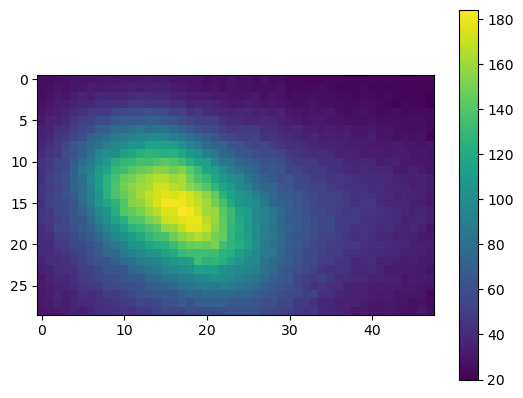

In [23]:
import h5py
import tensorflow as tf

class HDF5Dataset:
    def __init__(self, file_path, data_key):
        self.file_path = file_path
        self.data_key = data_key

        # Open the HDF5 file
        self.h5file = h5py.File(file_path, 'r')
        # Get the HDF5 dataset
        self.data = self.h5file[data_key][:]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index]
        image = image / 255
        return image

# Specify the path to the HDF5 file and the dataset key
file_path = '/home/ferroelectric/RHEED_paper/m3_learning/m3_learning/papers/2023_RHEED_PLD_SrTiO3/Datasets/test6_gaussian_fit_parameters_all-04232023.h5'
dataset_key = 'growth_1/spot_2/raw_image'

# Create an instance of the HDF5Dataset
dataset = HDF5Dataset(file_path, dataset_key)

# Convert the PyTorch Dataset to TensorFlow Dataset
tf_dataset = tf.data.Dataset.from_tensor_slices(dataset.data)

# Preprocess and batch the data
batch_size = 300
# tf_dataset = tf_dataset.map(lambda x: x / x.max())  # Normalization
tf_dataset = tf_dataset.batch(batch_size).shuffle(buffer_size=len(dataset))

print(tf_dataset)
import matplotlib.pyplot as plt
im=next(iter(tf_dataset))
plt.imshow(im[0])
plt.colorbar()
plt.show()


255.0
1.0


2023-07-28 15:21:56.077391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [13189,29,48]
	 [[{{node Placeholder/_0}}]]
2023-07-28 15:21:56.077617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [13189,29,48]
	 [[{{node Placeholder/_0}}]]


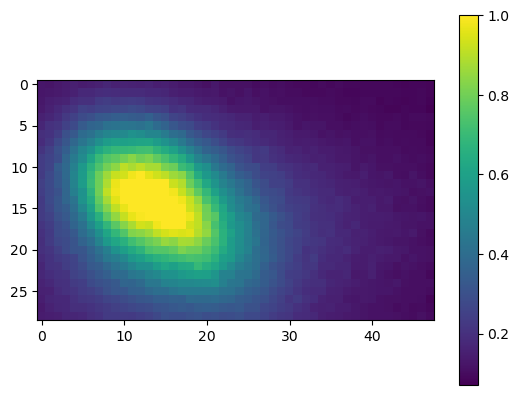

In [30]:
import h5py
import numpy as np
import tensorflow as tf
batch_size=1000

file_path = '/home/ferroelectric/RHEED_paper/m3_learning/m3_learning/papers/2023_RHEED_PLD_SrTiO3/Datasets/test6_gaussian_fit_parameters_all-04232023.h5'
dataset_key = 'growth_1/spot_2/raw_image'

with h5py.File(file_path, 'r') as h5_file:
    raw_images = h5_file[dataset_key][:]


raw_images = raw_images.astype(np.float32) / np.max(raw_images)



dataset = tf.data.Dataset.from_tensor_slices(raw_images)
dataset = dataset.shuffle(len(raw_images)).batch(batch_size)

im=next(iter(dataset))
plt.imshow(im[0])
plt.colorbar()

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

class LeNet5(tf.keras.Model):
    def __init__(self, func, num_classes,l2_strength=0.01, flag=False):
        super(LeNet5, self).__init__()
        self.layer1 = tf.keras.Sequential([
            layers.Conv2D(6, kernel_size=5, strides=1, padding='valid', input_shape=(29, 48, 1),kernel_regularizer=regularizers.l2(l2_strength)),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.MaxPool2D(pool_size=4, strides=4)
        ])
        self.layer2 = tf.keras.Sequential([
            layers.Conv2D(16, kernel_size=5, strides=1, padding='valid',kernel_regularizer=regularizers.l2(l2_strength)),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.MaxPool2D(pool_size=2, strides=2)
        ])
        self.fc = layers.Dense(48,kernel_regularizer=regularizers.l2(l2_strength))
        self.relu = layers.ReLU()
        self.fc1 = layers.Dense(24,kernel_regularizer=regularizers.l2(l2_strength))
        self.relu1 = layers.ReLU()
        self.fc2 = layers.Dense(num_classes,kernel_regularizer=regularizers.l2(l2_strength))
        self.func = func
        self.flag = flag
        self.flatten=layers.Flatten()

    def call(self, x):
        x = tf.cast(x, tf.float32)
        
        # print(x.shape)
        out = self.layer1(x)
        # print(out.shape)
        out = self.layer2(out)
        # print(out.shape)
        out=self.flatten(out)
        # print(out.shape)
        out = self.fc(out)
        # print(out.shape)

        out = self.relu(out)
        # print(out.shape)
        out = self.fc1(out)
        # print(out.shape)
        out = self.relu1(out)
        # print(out.shape)
        embedding = self.fc2(out)

        
        final = self.func(embedding)
        # print(embedding[0])
        if self.flag:
            return out, embedding, final

        return final

# Create an instance of the LeNet5 model
num_classes = 5  # Replace with the number of classes for your specific problem
func = tf.nn.softmax  # Replace with the gaussian after
model = LeNet5(func, num_classes)

# To see the model summary
model.build(input_shape=(None, 29, 48, 1))
model.summary()


Model: "le_net5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 6, 11, 6)          180       
                                                                 
 sequential_1 (Sequential)   (None, 1, 3, 16)          2480      
                                                                 
 dense (Dense)               multiple                  2352      
                                                                 
 re_lu_2 (ReLU)              multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  1176      
                                                                 
 re_lu_3 (ReLU)              multiple                  0         
                                                                 
 dense_2 (Dense)             multiple                  125 

In [3]:
import tensorflow as tf

class GaussianGenerator(tf.keras.layers.Layer):
    def __init__(self, img_dim):
        super(GaussianGenerator, self).__init__()
        self.img_dim = img_dim

    def call(self, params):
        batch_size = params.shape[0]
        mean_x, mean_y, cov_x, cov_y, theta = tf.unstack(params, axis=-1)

        x = tf.range(self.img_dim[1], dtype=tf.float32)
        y = tf.range(self.img_dim[0], dtype=tf.float32)
        x, y = tf.meshgrid(x, y)

        x = tf.expand_dims(x, axis=0)
        y = tf.expand_dims(y, axis=0)

        x = tf.repeat(x, batch_size, axis=0)
        y = tf.repeat(y, batch_size, axis=0)
        

        rota_matrix = tf.stack([tf.cos(theta), -tf.sin(theta), tf.sin(theta), tf.cos(theta)], axis=-1)
        rota_matrix = tf.reshape(rota_matrix, (batch_size, 2, 2))
        
       

        
        xy = tf.stack([x - tf.expand_dims((tf.expand_dims(mean_x, axis=-1)),axis=-1), y - tf.expand_dims((tf.expand_dims(mean_y, axis=-1)),axis=-1)], axis=-1)
        xy = tf.einsum('bijk,bkl->bijl', xy, rota_matrix)

        img = tf.exp(-0.5 * (xy[:, :, :, 0]**2 / ((tf.expand_dims((tf.expand_dims(cov_x, axis=-1)),axis=-1))**2) + xy[:, :, :, 1]**2 / ((tf.expand_dims((tf.expand_dims(cov_y, axis=-1)),axis=-1))**2)))

        
        return tf.expand_dims(img, axis=-1)

# Create an instance of the GaussianGenerator model
img_dim = (29, 48)  # Replace with the desired image dimensions
model = GaussianGenerator(img_dim)

# Generate sample parameters for testing
sample_params = tf.constant([0.2, 0.2, 5.0, 5.0, 0.2], dtype=tf.float32)

# Reshape the sample_params tensor to have a batch dimension
sample_params_batched = tf.expand_dims(sample_params, axis=0)

# Call the model to generate the Gaussian image
generated_img = model(sample_params_batched)


# Display the generated image shape
print("Generated Image Shape:", generated_img.shape)


Generated Image Shape: (1, 29, 48, 1)


In [15]:
func=GaussianGenerator  
num_classes=5

model = LeNet5(func, num_classes, flag=True)  # Set the flag to True to get all outputs
i=0
# Assuming you have a sample input 'input_data'

for i in range(10):
    images = next(iter(data_loader))
    output1, output2, output3 = model(images)
    print('output1')
    print(output1)
    print('output2')
    print(output2)
    print('output3')
    print(output3)
    


tf.Tensor([ 1.1514014 -2.433038   2.9635642 -3.5726528 -1.5133448], shape=(5,), dtype=float32)
output1
tf.Tensor(
[[3.5967958 0.        1.2522831 ... 0.9693999 5.2043567 2.0440073]
 [3.2586136 0.        1.138349  ... 1.0185108 5.425493  1.5914776]
 [3.3192365 0.        1.3744769 ... 1.3193239 5.6146197 1.9167154]
 ...
 [4.9539733 2.3468652 3.2601159 ... 0.9499955 5.095797  2.469029 ]
 [4.645586  2.1734638 3.401171  ... 1.1270993 5.469269  2.5747495]
 [4.730029  2.359799  3.236403  ... 1.3111637 5.556495  2.3476772]], shape=(5000, 24), dtype=float32)
output2
tf.Tensor(
[[ 1.1514014 -2.433038   2.9635642 -3.5726528 -1.5133448]
 [ 1.2055271 -2.3561504  2.8218803 -3.6475825 -1.490648 ]
 [ 1.2209433 -2.1434896  3.0475166 -3.8414035 -1.4981494]
 ...
 [ 1.4557402 -1.7791343  5.4114556 -4.6900673 -3.9774323]
 [ 1.5329745 -1.8475934  5.504947  -4.9309287 -3.7387257]
 [ 1.5767717 -1.7435884  5.1855145 -5.079905  -3.6992793]], shape=(5000, 5), dtype=float32)
output3
tf.Tensor([ 1.3248777 -1.75827

In [9]:
print(len(data_loader))

14


In [73]:
def ssim_loss(y_true, y_pred):
    return 1 - tf.image.ssim(y_true, y_pred, max_val=1.0)

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers, callbacks


# Create an instance of the LeNet5 model
img_dim = (29, 48)
num_classes = 5
net = LeNet5(GaussianGenerator(img_dim), num_classes)

# Define the loss function
criterion = losses.MeanSquaredError()
# criterion = losses.BinaryFocalCrossentropy()
# criterion= ssim_loss

# Define the optimizer
lr = 1e-9
optimizer = optimizers.Adam(learning_rate=lr)

# Load the dataset
file_path = '/home/ferroelectric/RHEED_paper/m3_learning/m3_learning/papers/2023_RHEED_PLD_SrTiO3/Datasets/test6_gaussian_fit_parameters_all-04232023.h5'
dataset_key = 'growth_1/spot_2/raw_image'
# dataset = HDF5Dataset(file_path, dataset_key)

# Create a data loader for the dataset
batch_size = 1000
# data_loader = tf.data.Dataset.from_tensor_slices(dataset.data)
# data_loader = data_loader.shuffle(buffer_size=len(dataset)).batch(batch_size)

# Define the number of epochs
num_epochs = 50

# Define the learning rate schedule
def lr_schedule(epoch, lr):
    if epoch < num_epochs // 2:
        return lr
    else:
        return lr * 0.1

# Create a learning rate scheduler callback
lr_scheduler = callbacks.LearningRateScheduler(lr_schedule)

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0

    for images in dataset:
        images = tf.expand_dims(images, axis=-1)
        with tf.GradientTape() as tape:
            outputs = net(images)
            # Calculate the loss
            loss = criterion(images, outputs)

        # Calculate gradients and update weights
        gradients = tape.gradient(loss, net.trainable_variables)
        optimizer.apply_gradients(zip(gradients, net.trainable_variables))

        running_loss += loss.numpy()

    average_loss = running_loss / len(dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}")
    updated_lr = lr_schedule(epoch, lr)
    optimizer.learning_rate.assign(updated_lr)

# Save the trained model
net.save_weights('best-model.h5')


Epoch [1/50], Loss: 0.05491038092545101
Epoch [2/50], Loss: 0.05516126352761473
Epoch [3/50], Loss: 0.055011805413024764
Epoch [4/50], Loss: 0.05516577671681132
Epoch [5/50], Loss: 0.05508360319903919
Epoch [6/50], Loss: 0.05538111472768443
Epoch [7/50], Loss: 0.05507979542016983
Epoch [8/50], Loss: 0.05482308992317745
Epoch [9/50], Loss: 0.054889596200415065
Epoch [10/50], Loss: 0.05539919435977936
Epoch [11/50], Loss: 0.05503210451986108
Epoch [12/50], Loss: 0.05507080203720501
Epoch [13/50], Loss: 0.055242977504219325
Epoch [14/50], Loss: 0.05504524814231055
Epoch [15/50], Loss: 0.055287567366446765
Epoch [16/50], Loss: 0.055171274447015355
Epoch [17/50], Loss: 0.05520428850182465
Epoch [18/50], Loss: 0.05537806770631245
Epoch [19/50], Loss: 0.05514219669359071
Epoch [20/50], Loss: 0.05504591523536614
Epoch [21/50], Loss: 0.05485286350761141
Epoch [22/50], Loss: 0.055161568469234874
Epoch [23/50], Loss: 0.05475321491914136
Epoch [24/50], Loss: 0.054996325767466
Epoch [25/50], Loss: 

In [8]:
net=img_dim = (29, 48)
num_classes = 5
net = LeNet5(GaussianGenerator(img_dim), num_classes)
net.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=['accuracy'])
history = net.fit(dataset, batch_size=1000, epochs=40)

Epoch 1/40


ValueError: in user code:

    File "/home/ferroelectric/micromamba/envs/pytorch/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/ferroelectric/micromamba/envs/pytorch/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ferroelectric/micromamba/envs/pytorch/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/ferroelectric/micromamba/envs/pytorch/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/ferroelectric/micromamba/envs/pytorch/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_filezemlnmcm.py", line 19, in tf__call
        final = ag__.converted_call(ag__.ld(self).func, (ag__.ld(embedding),), None, fscope)
    File "/tmp/__autograph_generated_filexdqd5bat.py", line 17, in tf__call
        x = ag__.converted_call(ag__.ld(tf).repeat, (ag__.ld(x), ag__.ld(batch_size)), dict(axis=0), fscope)

    ValueError: Exception encountered when calling layer 'le_net5_4' (type LeNet5).
    
    in user code:
    
        File "/tmp/ipykernel_164758/3108899384.py", line 49, in call  *
            final = self.func(embedding)
        File "/home/ferroelectric/micromamba/envs/pytorch/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/tmp/__autograph_generated_filexdqd5bat.py", line 17, in tf__call
            x = ag__.converted_call(ag__.ld(tf).repeat, (ag__.ld(x), ag__.ld(batch_size)), dict(axis=0), fscope)
    
        ValueError: Exception encountered when calling layer 'gaussian_generator_3' (type GaussianGenerator).
        
        in user code:
        
            File "/tmp/ipykernel_164758/409453181.py", line 21, in call  *
                x = tf.repeat(x, batch_size, axis=0)
        
            ValueError: None values not supported.
        
        
        Call arguments received by layer 'gaussian_generator_3' (type GaussianGenerator):
          • params=tf.Tensor(shape=(None, 5), dtype=float32)
    
    
    Call arguments received by layer 'le_net5_4' (type LeNet5):
      • x=tf.Tensor(shape=(None, 29, 48), dtype=float32)


In [26]:
net.summary()


Model: "le_net5_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_20 (Sequential)  (None, 6, 11, 6)          180       
                                                                 
 sequential_21 (Sequential)  (None, 1, 3, 16)          2480      
                                                                 
 dense_30 (Dense)            multiple                  2352      
                                                                 
 re_lu_42 (ReLU)             multiple                  0         
                                                                 
 dense_31 (Dense)            multiple                  1176      
                                                                 
 re_lu_43 (ReLU)             multiple                  0         
                                                                 
 dense_32 (Dense)            multiple                  1

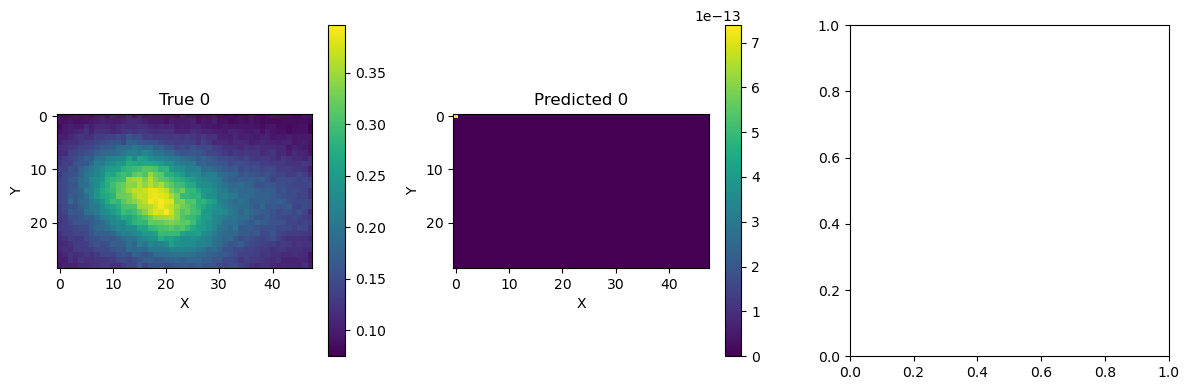

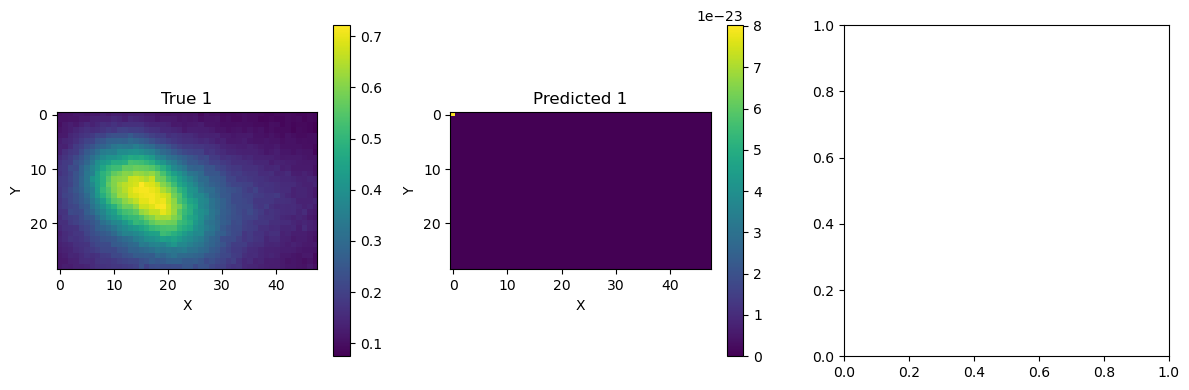

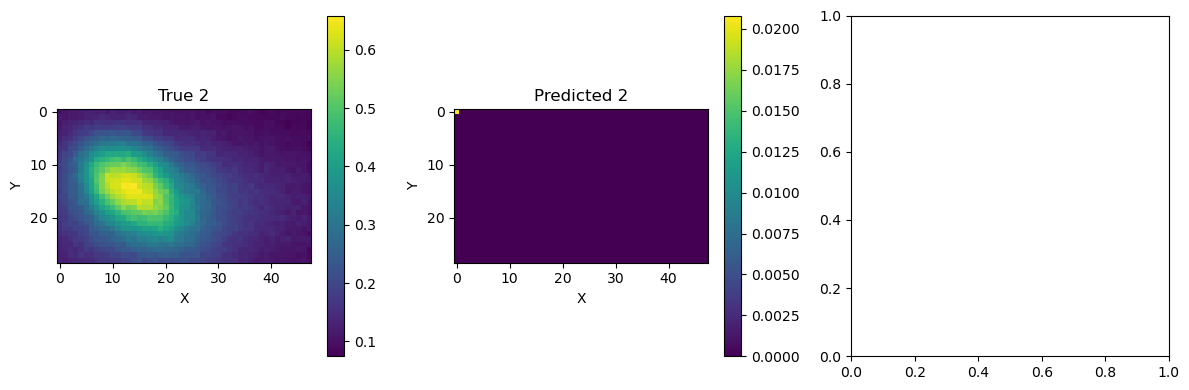

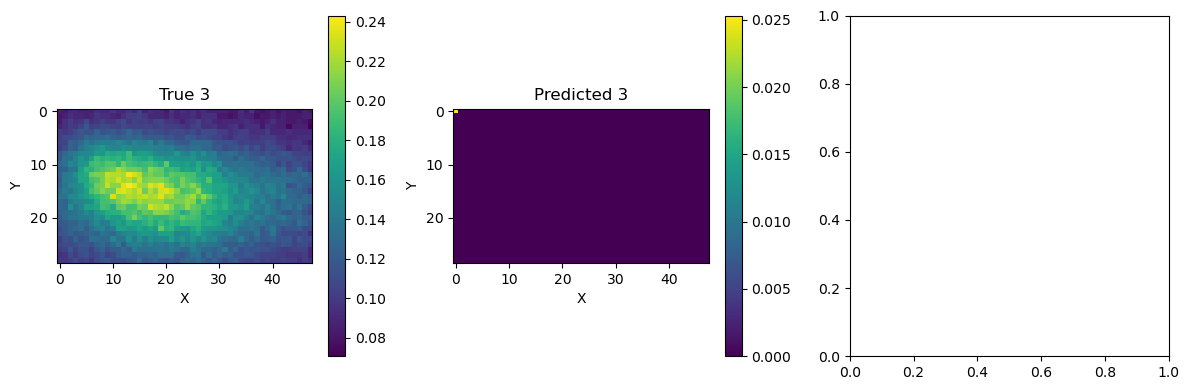

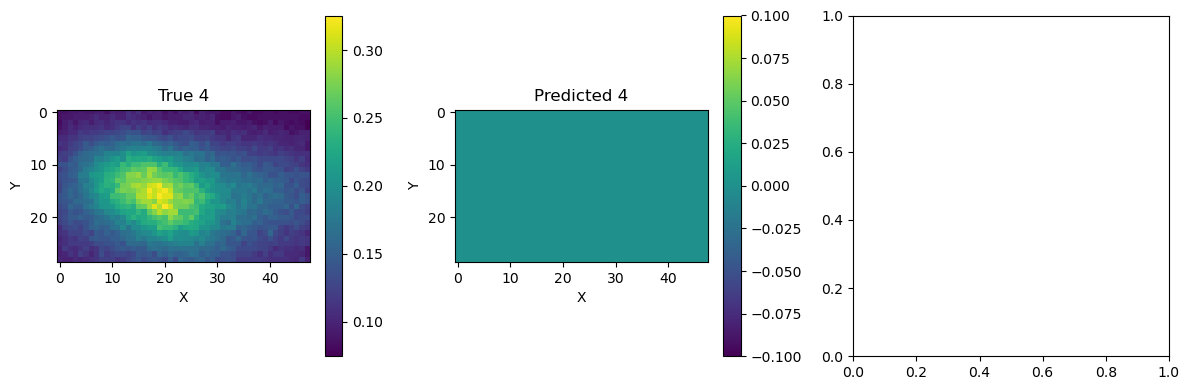

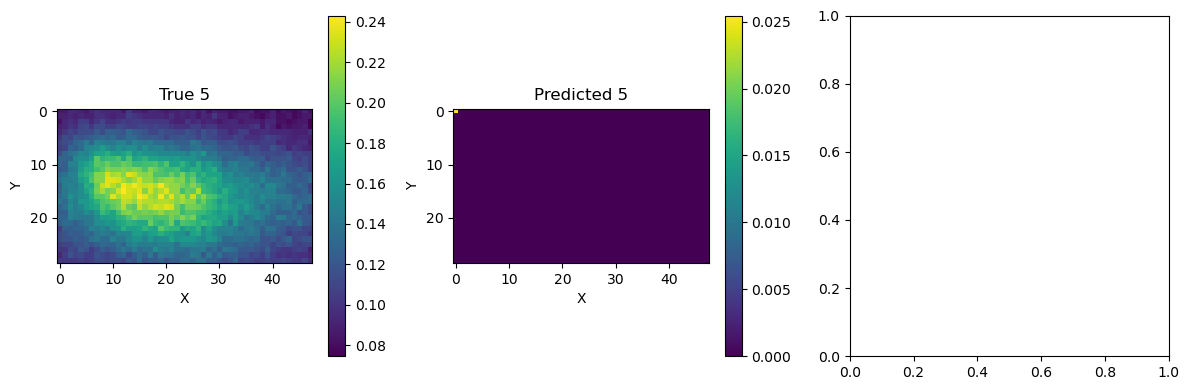

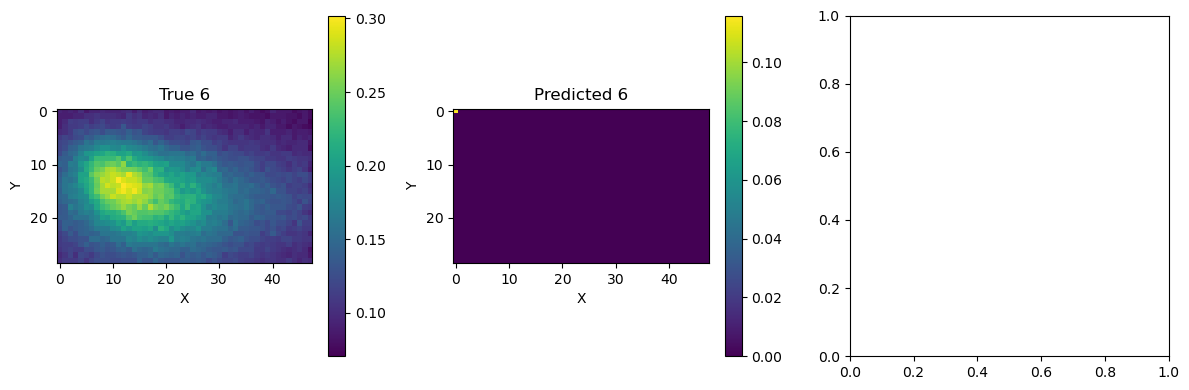

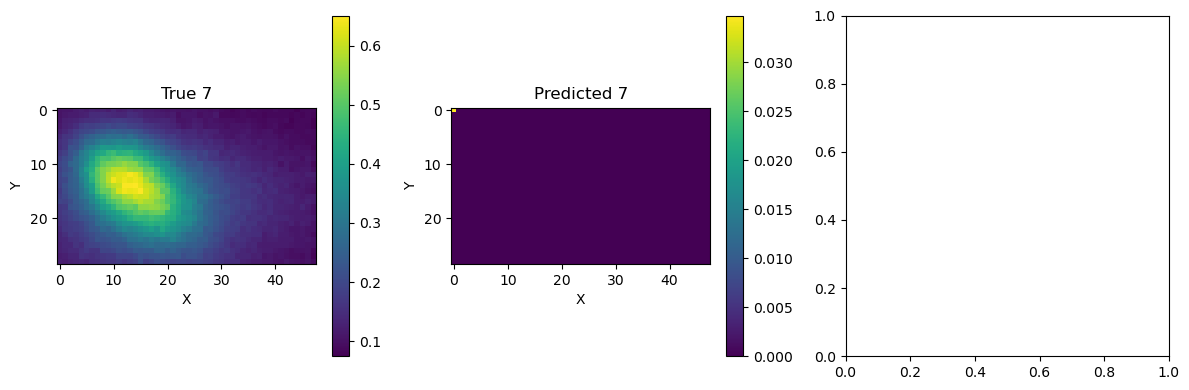

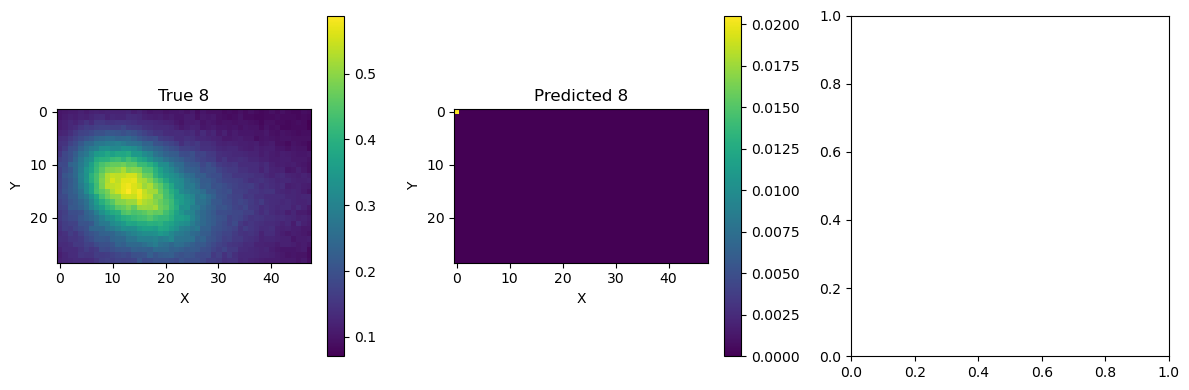

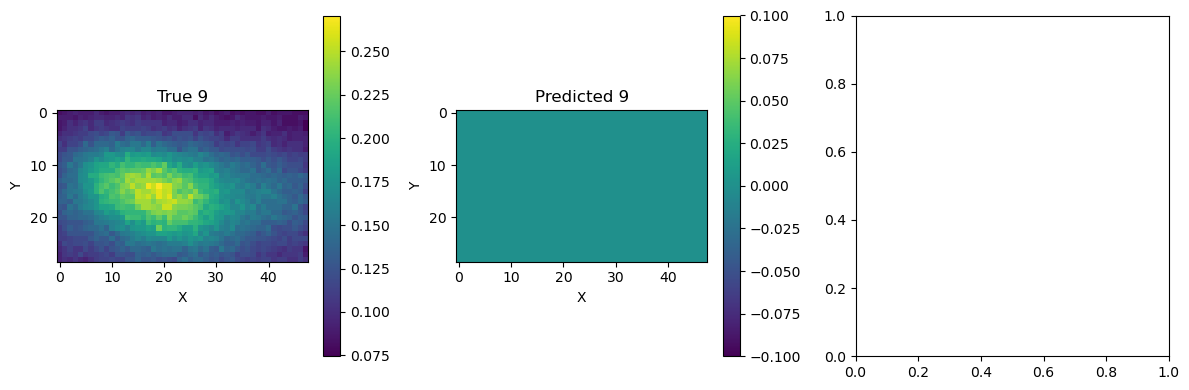

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
import h5py
import matplotlib.pyplot as plt

data = next(iter(dataset))
outputs = net(data)
path = '/home/ferroelectric/RHEED_paper/m3_learning/m3_learning/papers/2023_RHEED_PLD_SrTiO3/Datasets/test6_gaussian_fit_parameters_all-04232023.h5'
manual_im=[]
with h5py.File(path, 'r') as h5:
    for i in range(100):
        manual_im.append(h5['growth_1']['spot_2']['reconstructed_image'][i])
    

for i in range(10):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Plot true image
    im0 = axs[0].imshow(data[i])
    axs[0].set_title(f'True {i}')
    axs[0].set_xlabel('X')
    axs[0].set_ylabel('Y')
    fig.colorbar(im0, ax=axs[0])

    # Plot predicted image
    im1 = axs[1].imshow(outputs[i])
    axs[1].set_title(f'Predicted {i}')
    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')
    fig.colorbar(im1, ax=axs[1])

    plt.tight_layout()

    # Save the figure
    plt.savefig(f'OutputData/images_{i}.png')

    # Display the figure
    plt.show()
